# 特征工程入门与实践

参考：https://github.com/PacktPublishing/Feature-Engineering-Made-Easy


数据与书籍源代码可以从上述地址下载。

数据放到 `../data/feature_engineering` 目录中，运行本 Notebook

In [16]:
# import packages we need for exploratory data analysis (EDA)
import pandas as pd  # to store tabular data
import numpy as np  # to do some math
import matplotlib.pyplot as plt  # a popular data visualization tool
import seaborn as sns  # another popular data visualization tool
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline  
plt.style.use('fivethirtyeight')  # a popular data visualization theme

## 特征增强：清洗数据

### EDA， exploratory data analysis

In [13]:
# 使用匹马印第安人糖尿病预测数据集,其中 onset_diabetes 表示是否患病
pima_column_names = ['times_pregnant', 'plasma_glucose_concentration', 'diastolic_blood_pressure', 
                     'triceps_thickness', 'serum_insulin', 'bmi', 'pedigree_function', 'age', 
                     'onset_diabetes']
pima = pd.read_csv('../data/feature_engineering/pima.data', names=pima_column_names)

In [3]:
pima.head()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


通过直方图查看糖尿病人与正常人的区别。

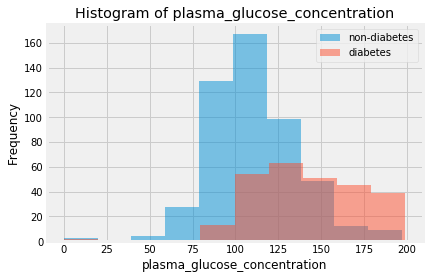

In [6]:
# plasma_glucose_concentration 列绘制直方图

col = 'plasma_glucose_concentration'
plt.hist(pima[pima['onset_diabetes'] == 0][col], bins=10, alpha=0.5, label='non-diabetes')
plt.hist(pima[pima['onset_diabetes'] == 1][col], bins=10, alpha=0.5, label='diabetes')
plt.legend(loc='upper right')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(col))
plt.show()

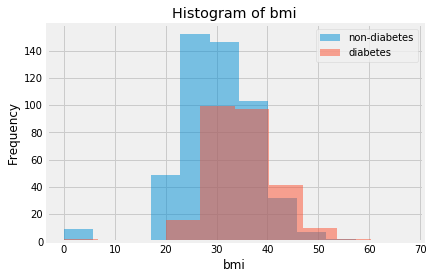

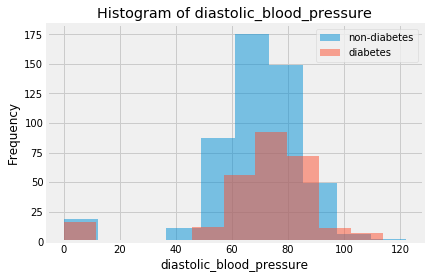

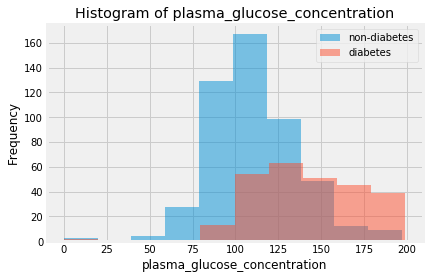

In [7]:
for col in ['bmi', 'diastolic_blood_pressure', 'plasma_glucose_concentration']:
    plt.hist(pima[pima['onset_diabetes']==0][col], 10, alpha=0.5, label='non-diabetes')
    plt.hist(pima[pima['onset_diabetes']==1][col], 10, alpha=0.5, label='diabetes')
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))
    plt.show()

可以看出血浆葡萄糖浓度、舒张压等相差大，两类人有明显区别，接下来使用相关矩阵衡量变量关系，画热力图，从而看出哪些特征对患病的相关度高。

理解皮尔逊相关系数：https://blog.csdn.net/huangfei711/article/details/78456165


In [9]:
# plasma_glucose_concentration 的重要性很高
pima.corr()['onset_diabetes']

times_pregnant                  0.221898
plasma_glucose_concentration    0.466581
diastolic_blood_pressure        0.065068
triceps_thickness               0.074752
serum_insulin                   0.130548
bmi                             0.292695
pedigree_function               0.173844
age                             0.238356
onset_diabetes                  1.000000
Name: onset_diabetes, dtype: float64

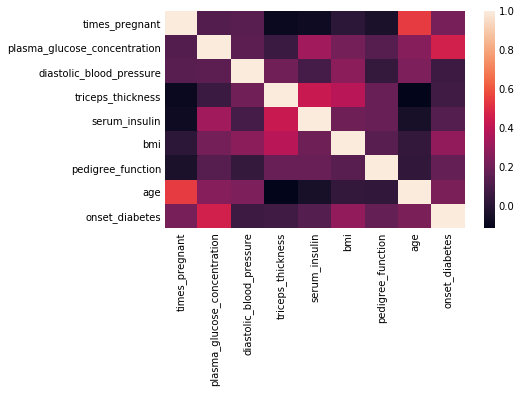

In [10]:
sns.heatmap(pima.corr())

### 识别与处理数据中的缺失值

In [12]:
# 以下代码看出没有缺失值
pima.isnull().sum()

times_pregnant                  0
plasma_glucose_concentration    0
diastolic_blood_pressure        0
triceps_thickness               0
serum_insulin                   0
bmi                             0
pedigree_function               0
age                             0
onset_diabetes                  0
dtype: int64

糖尿病发病率，空准确率

In [13]:
pima['onset_diabetes'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: onset_diabetes, dtype: float64

In [14]:
pima.describe()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


从上面的统计中可以看到 plasma_glucose_concentration 为0，不符合实际，说明数据可能用 0 填充了缺失值。

可以看出以下字段，本身不该有0，都用0填充了

- plasma_glucose_concentration
- diastolic_blood_pressure
- triceps_thickness
- serum_insulin
- bmi

缺失值的形式可能有：

- 0
- unkown
- ?

### 处理缺失值

- 删除
- 填充

In [16]:
pima['serum_insulin'].isnull().sum()

0

In [17]:
# 手动将缺失值转为 None
pima['serum_insulin'] = pima['serum_insulin'].map(lambda x:x if x != 0 else None)

In [18]:
pima['serum_insulin'].isnull().sum()

374

In [33]:
help(pd.DataFrame.replace)

Help on function replace in module pandas.core.frame:

replace(self, to_replace=None, value=None, inplace=False, limit=None, regex=False, method='pad')
    Replace values given in `to_replace` with `value`.
    
    Values of the DataFrame are replaced with other values dynamically.
    This differs from updating with ``.loc`` or ``.iloc``, which require
    you to specify a location to update with some value.
    
    Parameters
    ----------
    to_replace : str, regex, list, dict, Series, int, float, or None
        How to find the values that will be replaced.
    
        * numeric, str or regex:
    
            - numeric: numeric values equal to `to_replace` will be
              replaced with `value`
            - str: string exactly matching `to_replace` will be replaced
              with `value`
            - regex: regexs matching `to_replace` will be replaced with
              `value`
    
        * list of str, regex, or numeric:
    
            - First, if `to_replace

In [15]:
# 批量转换
columns = ['serum_insulin','bmi','plasma_glucose_concentration','diastolic_blood_pressure','triceps_thickness']

for col in columns:
    # 注意，这里替换需要用 [] 包裹，否则无法正确替换为 None.
    # 直接写成 (0, None) ，0 依然是0，因为数据格式是 数值
    pima[col].replace([0], [None], inplace=True)
    
pima.isnull().sum() 

times_pregnant                    0
plasma_glucose_concentration      5
diastolic_blood_pressure         35
triceps_thickness               227
serum_insulin                   374
bmi                              11
pedigree_function                 0
age                               0
onset_diabetes                    0
dtype: int64

In [57]:
pima.describe()

,times_pregnant,pedigree_function,age,onset_diabetes
count,768.000000,768.000000,768.000000,768.000000
mean,3.845052,0.471876,33.240885,0.348958
std,3.369578,0.331329,11.760232,0.476951
min,0.000000,0.078000,21.000000,0.000000
25%,1.000000,0.243750,24.000000,0.000000
50%,3.000000,0.372500,29.000000,0.000000
75%,6.000000,0.626250,41.000000,1.000000
max,17.000000,2.420000,81.000000,1.000000


In [58]:
pima.head()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
0,6,148,72,35,None,33.6,0.627,50,1
1,1,85,66,29,None,26.6,0.351,31,0
2,8,183,64,None,None,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [59]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
times_pregnant                  768 non-null int64
plasma_glucose_concentration    763 non-null object
diastolic_blood_pressure        733 non-null object
triceps_thickness               541 non-null object
serum_insulin                   394 non-null object
bmi                             757 non-null object
pedigree_function               768 non-null float64
age                             768 non-null int64
onset_diabetes                  768 non-null int64
dtypes: float64(1), int64(3), object(5)
memory usage: 54.1+ KB


In [16]:
# 查看plasma_glucose_concentration缺失值的内容
empty_plasma_index = pima[pima['plasma_glucose_concentration'].isnull()].index
pima.loc[empty_plasma_index]['plasma_glucose_concentration']

75     None
182    None
342    None
349    None
502    None
Name: plasma_glucose_concentration, dtype: object

填充缺失值

In [4]:
# 直接删除缺失行
pima_dropped = pima.dropna()
num_rows_lost = round(100 * (pima.shape[0] - pima_dropped.shape[0]) / pima.shape[0])
print("retained {}% of rows".format(num_rows_lost))

retained 49% of rows


删除数据前后类别比例相差不大

In [63]:
pima['onset_diabetes'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: onset_diabetes, dtype: float64

In [64]:
pima_dropped['onset_diabetes'].value_counts(normalize=True) 

0    0.668367
1    0.331633
Name: onset_diabetes, dtype: float64

查看下 删除行 之后，各个特征均值的差异

**用变化比例来查看，不要用肉眼观察**

可以看到变化幅度较大，其实最好的方法是尽可能保留多一些的数据

Text(0, 0.5, '% change')

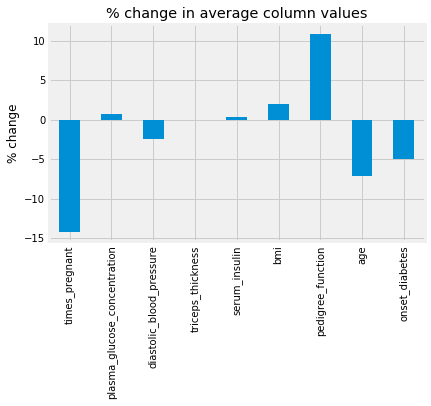

In [5]:

ax = (100*(pima_dropped.mean()-pima.mean())/pima.mean()).plot(kind='bar', title='% change in average column values')
ax.set_ylabel('% change')

使用删除缺失值后的数据进行模型学习

In [9]:
# now lets do some machine learning

# note we are using the dataset with the dropped rows

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X_dropped = pima_dropped.drop('onset_diabetes', axis=1)
# create our feature matrix by removing the response variable
print("learning from {} rows".format(X_dropped.shape[0]))
y_dropped = pima_dropped['onset_diabetes']


# our grid search variables and instances

# KNN parameters to try
knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7]}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X_dropped, y_dropped)

print(grid.best_score_, grid.best_params_)
# but we are learning from way fewer rows..

learning from 392 rows


C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7448979591836735 {'n_neighbors': 7}


C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


缺失值填充

In [18]:
# 填充平均值
pima['plasma_glucose_concentration'].fillna(pima['plasma_glucose_concentration'].mean(), inplace=True)

In [11]:
pima.isnull().sum()

times_pregnant                    0
plasma_glucose_concentration      0
diastolic_blood_pressure         35
triceps_thickness               227
serum_insulin                   374
bmi                              11
pedigree_function                 0
age                               0
onset_diabetes                    0
dtype: int64

In [19]:
pima.loc[empty_plasma_index]['plasma_glucose_concentration']

75     121.686763
182    121.686763
342    121.686763
349    121.686763
502    121.686763
Name: plasma_glucose_concentration, dtype: float64

需要在划分训练集和测试集之后进行填充，因为我们需要用训练数据结果应用到测试集中

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

In [27]:
X = pima.drop('onset_diabetes', axis=1).copy()
y = pima['onset_diabetes'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

In [28]:
data_set_mean = X_train.mean()
X_train = X_train.fillna(data_set_mean)
X_test = X_test.fillna(data_set_mean)
print(data_set_mean)

times_pregnant                    3.805556
plasma_glucose_concentration    122.100799
diastolic_blood_pressure         72.829137
triceps_thickness                29.203883
serum_insulin                   158.546053
bmi                              32.455245
pedigree_function                 0.479524
age                              33.248264
dtype: float64


In [29]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.734375

在机器学习流水线 Pipeline 中填充缺失值

In [75]:
knn_params = {'classify__n_neighbors': [1,2,3,4,5,6,7]}

knn = KNeighborsClassifier()

mean_inpute = Pipeline([('imputer', Imputer(strategy='mean')), 
                        ('classify', knn)
                       ])

grid = GridSearchCV(mean_inpute, knn_params)
grid.fit(X_train, y_train)

print(grid.best_score_, grid.best_params_)

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\

0.71875 {'classify__n_neighbors': 5}


C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuu

In [37]:
print(grid.best_score_, grid.best_params_)

0.71875 {'classify__n_neighbors': 5}


In [38]:
grid.score(X_test,y_test)

0.734375

### 标准化与归一化

- Z-score
- min-max
- 行归一化

特征尺度不一致需要标准化，以下算法会受尺度影响

- KNN，依赖距离
- K-meas
- 逻辑回归，支持向量机，神经网络等如果使用梯度下降来学习权重；
- 主成分分析，特征向量偏向于较大的列

In [39]:
impute = Imputer(strategy='mean')
pima_imputed_mean = pd.DataFrame(impute.fit_transform(pima), columns=pima_column_names)

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000204F5A94710>,
      dtype=object)

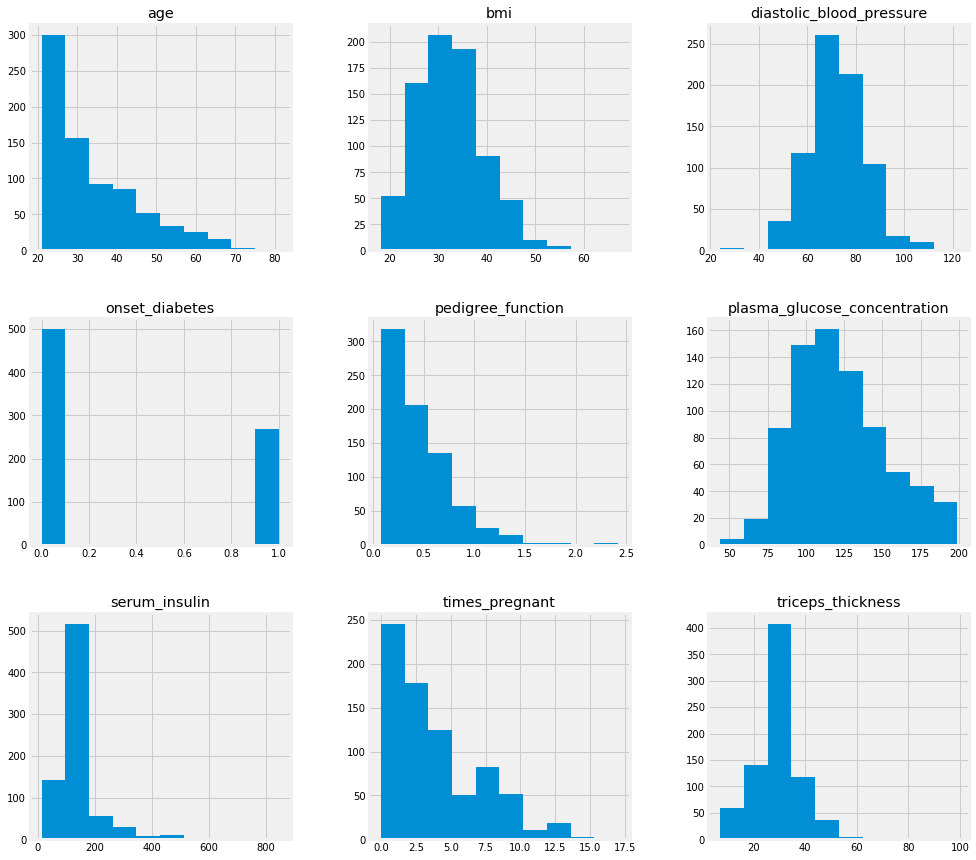

In [40]:
pima_imputed_mean.hist(figsize=(15,15))

上面的图看出数据分布（最小、最大值、标准差差别大），特征尺度不一致。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000204F55AE668>,
      dtype=object)

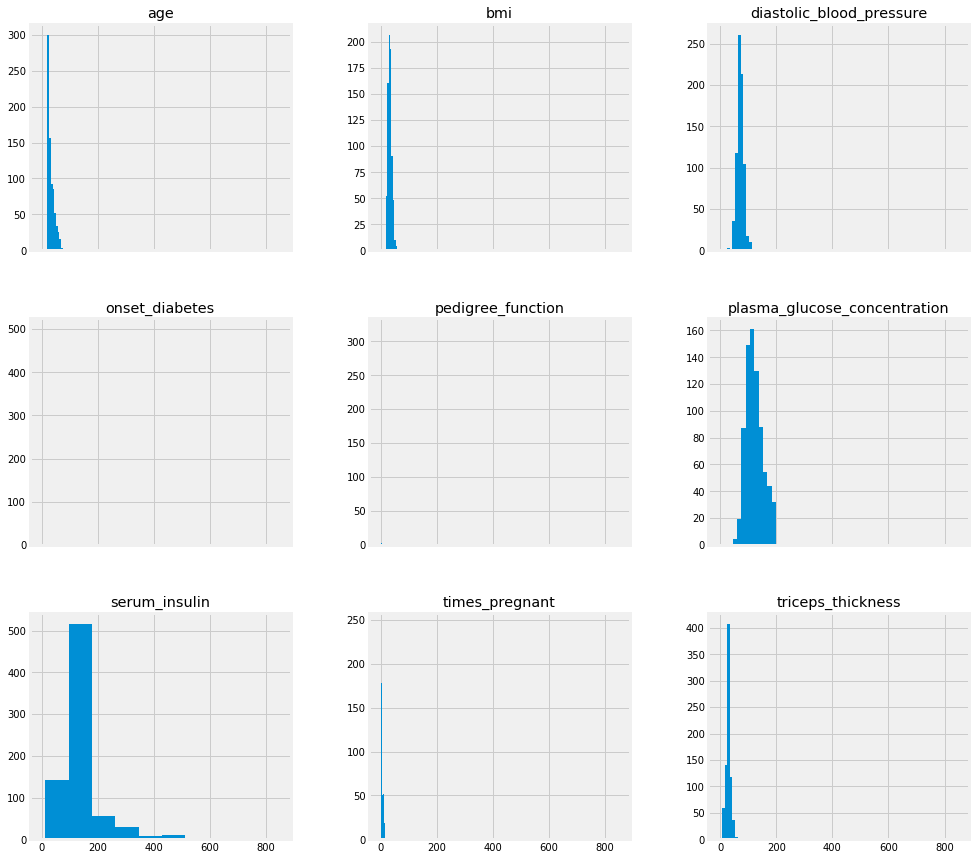

In [42]:
pima_imputed_mean.hist(figsize=(15, 15), sharex=True)

z-score 标准化 

$$z=(x-\mu)/\sigma$$

In [43]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

In [44]:
# 标准化前的均值和方差
pima['plasma_glucose_concentration'].mean(), pima['plasma_glucose_concentration'].std()

(121.68676277850587, 30.43594886720766)

Text(0.5, 1.0, 'Distribution of plasma_glucose_concentration')

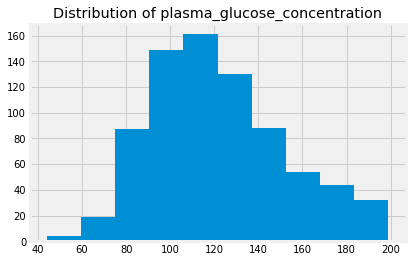

In [46]:
ax = pima['plasma_glucose_concentration'].hist()
ax.set_title('Distribution of plasma_glucose_concentration')

In [47]:
glucose_z_score_standardized = StandardScaler().fit_transform(pima[['plasma_glucose_concentration']])
glucose_z_score_standardized.mean(), glucose_z_score_standardized.std()

(-3.561965537339044e-16, 1.0)

Text(0.5, 1.0, 'Distribution of plasma_glucose_concentration after Z Score Scaling')

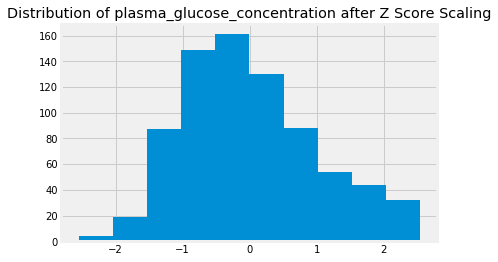

In [71]:
ax = pd.Series(glucose_z_score_standardized.reshape(-1)).hist()
ax.set_title('Distribution of plasma_glucose_concentration after Z Score Scaling')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000204F63A3390>,
      dtype=object)

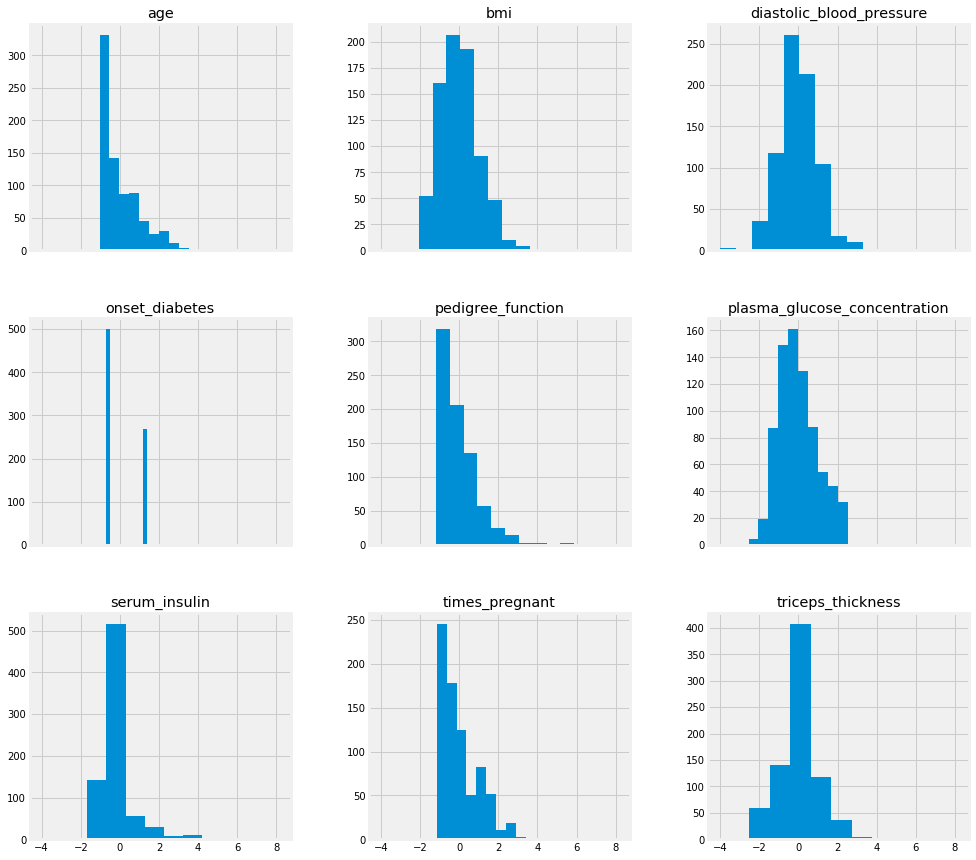

In [72]:
scale = StandardScaler()  # instantiate a z-scaler object

pima_imputed_mean_scaled = pd.DataFrame(scale.fit_transform(pima_imputed_mean), columns=pima_column_names)

pima_imputed_mean_scaled.hist(figsize=(15, 15), sharex=True)

In [78]:
knn_params = {'imputer__strategy':['mean', 'median'], 'classify__n_neighbors': [1,2,3,4,5,6,7]}

knn = KNeighborsClassifier()

mean_inpute = Pipeline([('imputer', Imputer(strategy='mean')), 
                        ('standardize', StandardScaler()),
                        ('classify', knn)
                       ])

grid = GridSearchCV(mean_inpute, knn_params)
grid.fit(X_train, y_train)

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuu

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'imputer__strategy': ['mean', 'median'], 'classify__n_neighbors': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [79]:
print(grid.best_score_, grid.best_params_)
print(grid.score(X_test, y_test))

0.7569444444444444 {'classify__n_neighbors': 7, 'imputer__strategy': 'mean'}
0.7604166666666666


Min-Max 标准化

In [82]:
knn_params = {'imputer__strategy':['mean', 'median'], 'classify__n_neighbors': [1,2,3,4,5,6,7]}

knn = KNeighborsClassifier()

mean_inpute = Pipeline([('imputer', Imputer(strategy='mean')), 
                        ('standardize', MinMaxScaler()),
                        ('classify', knn)
                       ])

grid = GridSearchCV(mean_inpute, knn_params)
grid.fit(X_train, y_train)

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\xukaihui\AppData\Local\Continuu

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardize', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classify', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'imputer__strategy': ['mean', 'median'], 'classify__n_neighbors': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [83]:
print(grid.best_score_, grid.best_params_)
print(grid.score(X_test, y_test))

0.7517361111111112 {'classify__n_neighbors': 7, 'imputer__strategy': 'mean'}
0.7760416666666666


行归一化

In [90]:
normalize = Normalizer()

pima_normalized = pd.DataFrame(normalize.fit_transform(pima.fillna(pima.mean())), columns=pima_column_names)
# 查看矩阵的平均范数
np.sqrt((pima_normalized**2).sum(axis=1)).mean()

1.0

In [ ]:
knn_params = {'imputer__strategy':['mean', 'median'], 'classify__n_neighbors': [1,2,3,4,5,6,7]}

knn = KNeighborsClassifier()

mean_inpute = Pipeline([('imputer', Imputer(strategy='mean')), 
                        ('standardize', Normalizer()),
                        ('classify', knn)
                       ])

grid = GridSearchCV(mean_inpute, knn_params)
grid.fit(X_train, y_train)

## 特征构造

In [96]:
# 手动构造一个数据
X = pd.DataFrame({'city': ['tokyo', None,'london', 'seattle', 'san francisco', 'tokyo'],
                 'boolean': ['yes', 'no', None, 'no', 'no', 'yes'], 
                  'ordinal_column':['somewhat like', 'like', 'somewhat like', 'like', 'somewhat like', 'dislike'], 
                  'quantitative_column':[1, 11, -.5, 10, None, 20]})
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


### 分类变量填充

In [98]:
X.isnull().sum()

city                   1
boolean                1
ordinal_column         0
quantitative_column    1
dtype: int64

使用出现频次最高的类别填充

In [99]:
X['city'].value_counts().index[0]

'tokyo'

In [100]:
X['city'].fillna(X['city'].value_counts().index[0])

0            tokyo
1            tokyo
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

In [ ]:
# 多列操作
df = df.apply(lambda x : x.fillna(x.value_counts().index[0]))

In [105]:
# 自定义分类填充器
from sklearn.base import TransformerMixin

class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self

In [106]:
cci = CustomCategoryImputer(cols=['city', 'boolean'])

In [107]:
cci.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


In [112]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

# 自定义填充器，填充定量列
class  CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
        
    def transform(self, df):
        X = df.copy()
        impute = Imputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    
    def fit(self, *_):
        return self

In [113]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')
cqi.fit_transform(X)

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


使用 Pipline 填充

In [117]:
imputer = Pipeline([('quant', cqi), ('category', cci)])
X = imputer.fit_transform(X)

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [118]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


### 编码分类变量

#### 定类等级编码

onehot

In [119]:
pd.get_dummies(X, columns=['city','boolean'], prefix_sep='__')

,ordinal_column,quantitative_column,city__london,city__san francisco,city__seattle,city__tokyo,boolean__no,boolean__yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,1,1,0
2,somewhat like,-0.5,1,0,0,0,1,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,8.3,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


In [126]:
# 自定义填充器

class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
    
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    
    def fit(self, *_):
        return self

In [127]:
cd = CustomDummifier(cols=['boolean', 'city'])
 
cd.fit_transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,somewhat like,1.0,0,1,0,0,0,1
1,like,11.0,1,0,0,0,0,1
2,somewhat like,-0.5,1,0,1,0,0,0
3,like,10.0,1,0,0,0,1,0
4,somewhat like,8.3,1,0,0,1,0,0
5,dislike,20.0,0,1,0,0,0,1


#### 定序等级编码

In [128]:
ordering = ['dislike', 'somewhat like', 'like']

print(X['ordinal_column'])

print(X['ordinal_column'].map(lambda x: ordering.index(x)))

0    somewhat like
1             like
2    somewhat like
3             like
4    somewhat like
5          dislike
Name: ordinal_column, dtype: object
0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64


In [134]:
# 自定义填充器

class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.col = col
        self.ordering = ordering
        
    def transform(self, df):
        df = df.copy()
        df[self.col]  = X[self.col].map(lambda x: self.ordering.index(x))
        return df
    
    def fit(self, *_):
        return self

In [135]:
ce = CustomEncoder(col='ordinal_column', ordering = ['dislike', 'somewhat like', 'like'])

ce.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,1,1.0
1,tokyo,no,2,11.0
2,london,no,1,-0.5
3,seattle,no,2,10.0
4,san francisco,no,1,8.3
5,tokyo,yes,0,20.0


#### 连续特征分箱

In [136]:
pd.cut(X['quantitative_column'], bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4    (6.333, 13.167]
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

In [137]:
# 设定参数编码
pd.cut(X['quantitative_column'], bins=3, labels=False)

0    0
1    1
2    0
3    1
4    1
5    2
Name: quantitative_column, dtype: int64

In [141]:
# 使用预定义标签
group_names = ['Low', 'Okay', 'Good']
pd.cut(X['quantitative_column'], bins=3, labels=group_names)

0     Low
1    Okay
2     Low
3    Okay
4    Okay
5    Good
Name: quantitative_column, dtype: category
Categories (3, object): [Low < Okay < Good]

In [142]:
# 自定义填充器

from sklearn.base import TransformerMixin

class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self

In [143]:
cc = CustomCutter(col='quantitative_column', bins=3)

cc.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,0
1,tokyo,no,like,1
2,london,no,somewhat like,0
3,seattle,no,like,1
4,san francisco,no,somewhat like,1
5,tokyo,yes,dislike,2


In [144]:
# 使用 Pipeline 填充
# imputer 为上面定义过的 imputer
pipe = Pipeline([('inputer',imputer),('dummify', cd), ('encode', ce), ('cut', cc)])


In [145]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


In [146]:
pipe.fit(X)

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Pipeline(memory=None,
     steps=[('inputer', Pipeline(memory=None,
     steps=[('quant', <__main__.CustomQuantitativeImputer object at 0x00000204F854CB00>), ('category', <__main__.CustomCategoryImputer object at 0x00000204F805D710>)])), ('dummify', <__main__.CustomDummifier object at 0x00000204F8A08748>), ('encode', <__main__.CustomEncoder object at 0x00000204F8CF0F28>), ('cut', <__main__.CustomCutter object at 0x00000204F8B234A8>)])

In [147]:
pipe.transform(X)

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,1,0,0,1,0,0,0,1
1,2,1,1,0,0,0,0,1
2,1,0,1,0,1,0,0,0
3,2,1,1,0,0,0,1,0
4,1,1,1,0,0,1,0,0
5,0,2,0,1,0,0,0,1


### 特征交叉，多项式特征

In [148]:
# 人体胸部加速度数据集,标签activity的数值为1-7
'''
1-在电脑前工作
2-站立、走路和上下楼梯
3-站立
4-走路
5-上下楼梯
6-与人边走边聊
7-站立着说话

'''

df = pd.read_csv('../data/feature_engineering/activity_recognizer/1.csv', header=None)
df.columns = ['index', 'x', 'y', 'z', 'activity']

df.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [149]:
df.shape

(162501, 5)

In [152]:
# 空准确率, 最大值 0.5153
df['activity'].value_counts(normalize=True)

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

In [153]:
# 直接训练看一看结果

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = df[['x', 'y', 'z']]
y = df['activity']

knn_params = {'n_neighbors': [3, 4, 5, 6 ]}

knn = KNeighborsClassifier()
grid = GridSearchCV(estimator=knn, param_grid=knn_params)

grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.720752487676999 {'n_neighbors': 5}


In [154]:
# 使用多项式交叉特征

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 9)

In [156]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


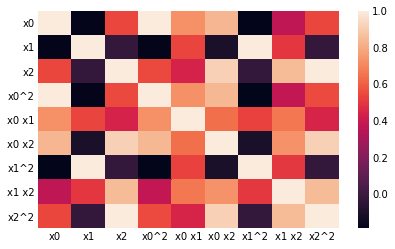

In [157]:
# 查看热力图

import seaborn as sns

sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [160]:
# 在 Pipeline 中使用

from sklearn.pipeline import Pipeline

pipe_params = {'poly_features__degree': [1,2,3], 
              'poly_features__interaction_only': [True, False],
              'classify__n_neighbors':[3, 4, 5, 6]}

pipe = Pipeline([('poly_features', poly), ('classify', knn)])

grid = GridSearchCV(estimator=pipe, param_grid=pipe_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.7211894080651812 {'classify__n_neighbors': 5, 'poly_features__degree': 2, 'poly_features__interaction_only': True}


### 文本特征

#### 词袋法

In [167]:
#http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/
tweets = pd.read_csv('../data/feature_engineering/twitter_sentiment.csv', encoding='latin1')
tweets.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [173]:
tweets.drop(['ItemID'], axis=1, inplace=True)

In [175]:
tweets.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [176]:
X = tweets['SentimentText']
y = tweets['Sentiment']

In [177]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english')  # removes a set of english stop words (if, a, the, etc)
_ = vect.fit_transform(X)
print(_.shape)

(99989, 105545)


In [178]:
vect.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [180]:
vect = CountVectorizer(ngram_range=(1, 5))  # also includes phrases up to 5 words
_ = vect.fit_transform(X)
print(_.shape)  # explodes the number of feature

(99989, 3219557)


In [181]:
vect.get_feature_names()[:15]

['00',
 '00 01',
 '00 01 minute',
 '00 01 minute after',
 '00 01 minute after applications',
 '00 10',
 '00 10 00',
 '00 56',
 '00 56 03',
 '00 56 03 beating',
 '00 56 03 beating my',
 '00 always',
 '00 always have',
 '00 always have such',
 '00 always have such warmth']

#### TF-IDF

In [183]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = CountVectorizer()
_ = vect.fit_transform(X)
print(_.shape, _[0, :].mean())

vect = TfidfVectorizer()
_ = vect.fit_transform(X)
print(_.shape, _[0, :].mean())

(99989, 105849) 6.613194267305311e-05
(99989, 105849) 2.1863060975751186e-05


In [184]:
y.value_counts(normalize=True)

1    0.564632
0    0.435368
Name: Sentiment, dtype: float64

In [187]:
# 特征很多，样本也多，使用朴素贝叶斯快速计算

from sklearn.naive_bayes import MultinomialNB

pipe_params = {'vect__ngram_range': [(1,1), (1,2)], 
               'vect__max_features': [1000, 10000],
              'vect__stop_words':[None, 'english']}

pipe = Pipeline([('vect', CountVectorizer()),('classify', MultinomialNB())])
grid = GridSearchCV(pipe, param_grid=pipe_params)

grid.fit(X,y)

print(grid.best_score_, grid.best_params_)

C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7557531328446129 {'vect__max_features': 10000, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}


In [188]:
# 合并特征
from sklearn.pipeline import FeatureUnion

featurizer = FeatureUnion([('tfidf_vect', TfidfVectorizer()), ('count_vect', CountVectorizer())])
_ = featurizer.fit_transform(X)
pipe_params = {'featurizer__count_vect__ngram_range':[(1, 1), (1, 2)], 'featurizer__count_vect__max_features':[1000, 10000], 'featurizer__count_vect__stop_words':[None, 'english'],
              'featurizer__tfidf_vect__ngram_range':[(1, 1), (1, 2)], 'featurizer__tfidf_vect__max_features':[1000, 10000], 'featurizer__tfidf_vect__stop_words':[None, 'english']}


pipe = Pipeline([('featurizer', featurizer), ('classify', MultinomialNB())])

grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)


C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7584334276770445 {'featurizer__count_vect__max_features': 10000, 'featurizer__count_vect__ngram_range': (1, 2), 'featurizer__count_vect__stop_words': None, 'featurizer__tfidf_vect__max_features': 10000, 'featurizer__tfidf_vect__ngram_range': (1, 1), 'featurizer__tfidf_vect__stop_words': 'english'}


## 特征选择

In [2]:
# 设定随机种子，让每次的随机数一样
np.random.seed(123)

In [3]:
# https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
# 信用卡逾期数据集
credit_card_default = pd.read_csv('../data/feature_engineering//credit_card_default.csv')

In [4]:
credit_card_default.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
credit_card_default.shape

(30000, 24)

In [6]:
credit_card_default.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


In [7]:
credit_card_default.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [8]:
X = credit_card_default.drop(['default payment next month'], axis=1)
y = credit_card_default['default payment next month']
# 空准确率
y.value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

建立一个方法，使用网格搜索获取最优模型和评价结果

In [56]:
from sklearn.model_selection import GridSearchCV
def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        error_score=0.)# if a parameter set raises an error, continue and set the performance as a big, fat 0
    grid.fit(X, y)
    
    # 最佳准确率
    print("Best Accuracy: {}".format(grid.best_score_))
    # 最佳模型参数
    print("Best parameters: {}".format(grid.best_params_))
    # 平均训练时间
    print("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    # 平均预测时间
    print("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))
    return grid

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

lr_params = {'C': [1e-1, 1e0, 1e1, 1e2], 'penalty': ['l1', 'l2']}
knn_params = {'n_neighbors': [1, 3, 5, 7]}
tree_params = {'max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
forest_params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 1, 3, 5, 7]}

lr = LogisticRegression()
knn = KNeighborsClassifier()
d_tree = DecisionTreeClassifier()
forest = RandomForestClassifier()

In [57]:
get_best_model_and_accuracy(lr, lr_params, X, y)

Best Accuracy: 0.8095
Best parameters: {'C': 0.1, 'penalty': 'l1'}
Average Time to Fit (s): 0.44
Average Time to Score (s): 0.002


GridSearchCV(cv='warn', error_score=0.0,
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1.0, 10.0, 100.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
get_best_model_and_accuracy(knn, knn_params, X, y)

Best Accuracy: 0.7602333333333333
Best parameters: {'n_neighbors': 7}
Average Time to Fit (s)
Average Time to Score (s)


GridSearchCV(cv='warn', error_score=0.0,
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 3, 5, 7]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

### 皮尔逊相关系数

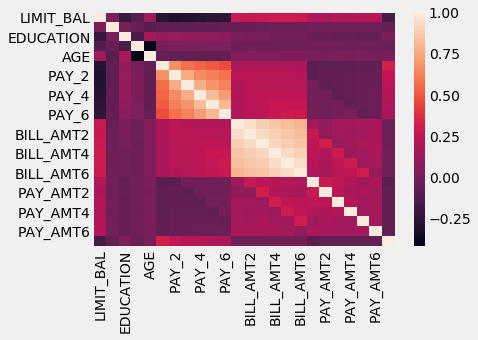

In [19]:
import seaborn as sns 

sns.heatmap(credit_card_default.corr())

In [20]:
credit_card_default.corr()['default payment next month']  

LIMIT_BAL                    -0.153520
SEX                          -0.039961
EDUCATION                     0.028006
MARRIAGE                     -0.024339
AGE                           0.013890
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
BILL_AMT1                    -0.019644
BILL_AMT2                    -0.014193
BILL_AMT3                    -0.014076
BILL_AMT4                    -0.010156
BILL_AMT5                    -0.006760
BILL_AMT6                    -0.005372
PAY_AMT1                     -0.072929
PAY_AMT2                     -0.058579
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT5                     -0.055124
PAY_AMT6                     -0.053183
default payment next month    1.000000
Name: default payment next month, dtype: float64

选取一定阈值的特征

In [21]:
credit_card_default.corr()['default payment next month'].abs() > 0.2

LIMIT_BAL                     False
SEX                           False
EDUCATION                     False
MARRIAGE                      False
AGE                           False
PAY_0                          True
PAY_2                          True
PAY_3                          True
PAY_4                          True
PAY_5                          True
PAY_6                         False
BILL_AMT1                     False
BILL_AMT2                     False
BILL_AMT3                     False
BILL_AMT4                     False
BILL_AMT5                     False
BILL_AMT6                     False
PAY_AMT1                      False
PAY_AMT2                      False
PAY_AMT3                      False
PAY_AMT4                      False
PAY_AMT5                      False
PAY_AMT6                      False
default payment next month     True
Name: default payment next month, dtype: bool

自定义转换器

In [32]:
from sklearn.base import TransformerMixin, BaseEstimator

class CustomCorrelationChooser(TransformerMixin, BaseEstimator):
    def __init__(self, response, cols_to_keep=[], threshold=None):
        # 目标列
        self.response = response
        # 阈值
        self.threshold = threshold
        # 需要保留的列
        self.cols_to_keep = cols_to_keep
        
    def transform(self, X):
        return X[self.cols_to_keep]
    
    def fit(self, X, *_):
        df = pd.concat([X, self.response], axis=1)
        self.cols_to_keep = df.columns[df.corr()[df.columns[-1]].abs() > self.threshold]
        self.cols_to_keep = [c for c in self.cols_to_keep if c in X.columns]
        return self

In [24]:
ccc = CustomCorrelationChooser(threshold=.2, response=y)

In [25]:
ccc.fit(X)

ccc.cols_to_keep

['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5']

In [26]:
ccc.transform(X).head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5
0,2,2,-1,-1,-2
1,-1,2,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,-1,0,-1,0,0


In [29]:
tree_pipe_params = {'classifier__max_depth': 
                    [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

In [33]:
from copy import deepcopy
from sklearn.pipeline import Pipeline
ccc = CustomCorrelationChooser(response=y)
ccc_pipe = Pipeline([('correlation_select', ccc), 
                     ('classifier', d_tree)])
# 拷贝参数字典
ccc_pipe_params = deepcopy(tree_pipe_params)
# 更新参数字典
ccc_pipe_params.update({
               'correlation_select__threshold':[0, .1, .2, .3]})
print(ccc_pipe_params)

get_best_model_and_accuracy(ccc_pipe, ccc_pipe_params, X, y)

{'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'correlation_select__threshold': [0, 0.1, 0.2, 0.3]}
Best Accuracy: 0.8206
Best parameters: {'classifier__max_depth': 5, 'correlation_select__threshold': 0.1}
Average Time to Fit (s)
Average Time to Score (s)


GridSearchCV(cv='warn', error_score=0.0,
       estimator=Pipeline(memory=None,
     steps=[('correlation_select', CustomCorrelationChooser(cols_to_keep=[],
             response=0        1
1        1
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       1
14       0
15       0
16       1
17       0
18      ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'correlation_select__threshold': [0, 0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### 假设检验 SelectKBest

In [39]:
from sklearn.feature_selection import SelectKBest
# This models a statistical test known as ANOVA
from sklearn.feature_selection import f_classif

k_best = SelectKBest(f_classif, k=5)
k_best.fit_transform(X, y )

p_values = pd.DataFrame({'column': X.columns, 'p_value': k_best.pvalues_}).sort_values('p_value')
p_values[p_values['p_value'] < .05]                                                                                      

,column,p_value
5,PAY_0,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279
10,PAY_6,7.296740e-234
0,LIMIT_BAL,1.302244e-157
17,PAY_AMT1,1.146488e-36
18,PAY_AMT2,3.166657e-24
20,PAY_AMT4,6.830942e-23


### 基于模型的特征选择

In [40]:
# 使用文本数据
tweets = pd.read_csv('../data/feature_engineering//twitter_sentiment.csv', 
                     encoding='latin1')

In [41]:
tweets.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [42]:
tweets_X, tweets_y = tweets['SentimentText'], tweets['Sentiment']

In [43]:
# null accuracy
tweets_y.value_counts(normalize=True)

1    0.564632
0    0.435368
Name: Sentiment, dtype: float64

#### 树模型特征选择

In [44]:
tree = DecisionTreeClassifier()

tree.fit(X, y)

importances = pd.DataFrame({'importance': tree.feature_importances_, 'feature':X.columns}).sort_values('importance', ascending=False)

importances.head()

,importance,feature
5,0.161425,PAY_0
4,0.073898,AGE
11,0.070728,BILL_AMT1
0,0.059788,LIMIT_BAL
19,0.055184,PAY_AMT3


In [45]:
from sklearn.feature_selection import SelectFromModel
select_from_model = SelectFromModel(DecisionTreeClassifier(), 
                                    threshold=.05)
selected_X = select_from_model.fit_transform(X, y)

In [46]:
selected_X.shape

(30000, 7)

In [47]:
select_from_model.get_params()

{'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__presort': False,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'max_features': None,
 'norm_order': 1,
 'prefit': False,
 'threshold': 0.05}

In [49]:
tree_pipe_params = {'classifier__max_depth': [1, 3, 5, 7]}
from sklearn.pipeline import Pipeline

select_from_pipe = Pipeline([('select', SelectFromModel(DecisionTreeClassifier())), 
                             ('classifier', d_tree)])

select_from_pipe_params = deepcopy(tree_pipe_params)

select_from_pipe_params.update({
              'select__threshold': [.01, .05, .1, "mean", "median", "2.*mean"],
              'select__estimator__max_depth': [None, 1, 3, 5, 7]
              })

print(select_from_pipe_params)

# not better than original
get_best_model_and_accuracy(select_from_pipe, 
                            select_from_pipe_params, 
                            X, y)  

{'classifier__max_depth': [1, 3, 5, 7], 'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'], 'select__estimator__max_depth': [None, 1, 3, 5, 7]}
Best Accuracy: 0.8202666666666667
Best parameters: {'classifier__max_depth': 3, 'select__estimator__max_depth': None, 'select__threshold': 0.01}
Average Time to Fit (s)
Average Time to Score (s)


GridSearchCV(cv='warn', error_score=0.0,
       estimator=Pipeline(memory=None,
     steps=[('select', SelectFromModel(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__max_depth': [1, 3, 5, 7], 'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'], 'select__estimator__max_depth': [None, 1, 3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### 线性模型特征选择

通过线性模型参数来进行选择

In [59]:
# l1 正则
lr = LogisticRegression(penalty='l1')

lr.fit(X, y)

importances = pd.DataFrame({'importance': lr.coef_.reshape(-1,), 
                            'feature':X.columns}).sort_values('importance', ascending=False)

importances[importances['importance'] >= .01]

,importance,feature
5,0.577008,PAY_0
6,0.082667,PAY_2
7,0.071973,PAY_3
9,0.033930,PAY_5
8,0.023888,PAY_4


In [58]:
logistic_selector = SelectFromModel(LogisticRegression())
regularization_pipe = Pipeline([('select', logistic_selector), 
                                ('classifier', tree)])
regularization_pipe_params = deepcopy(tree_pipe_params)

regularization_pipe_params.update({
              'select__threshold': [.01, .05, .1, "mean", "median", "2.*mean"],
              'select__estimator__penalty': ['l1', 'l2'],
              })
print(regularization_pipe_params)
get_best_model_and_accuracy(regularization_pipe, 
                            regularization_pipe_params, 
                            X, y) 

{'classifier__max_depth': [1, 3, 5, 7], 'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'], 'select__estimator__penalty': ['l1', 'l2']}
Best Accuracy: 0.8212
Best parameters: {'classifier__max_depth': 5, 'select__estimator__penalty': 'l1', 'select__threshold': 0.01}
Average Time to Fit (s): 0.437
Average Time to Score (s): 0.001


GridSearchCV(cv='warn', error_score=0.0,
       estimator=Pipeline(memory=None,
     steps=[('select', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__max_depth': [1, 3, 5, 7], 'select__threshold': [0.01, 0.05, 0.1, 'mean', 'median', '2.*mean'], 'select__estimator__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## 特征学习

**特征学习**方法，不依赖参数假设，而是依赖于随机学习，按照迭代轮次学习出最佳特征。特征学习往往使用深度学习算法。


### 受限玻尔兹曼机 RBM

In [3]:
import numpy as np
import math

# sigmoid function
def activation(x):
    return 1 / (1 + math.exp(-x))

inputs = np.array([1, 2, 3, 4])
weights = np.array([0.2, 0.324, 0.1, 0.001])
bias = 1.5

a = activation(np.dot(inputs, weights) + bias)

a

0.9341341524806636

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model, datasets, metrics
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [6]:
# create numpy array from csv
images = np.genfromtxt('../data/feature_engineering/mnist_train.csv', delimiter=',')

In [9]:
# 6000 images and 785 columns, 28X28 pixels + 1 response
images.shape

(6000, 785)

In [10]:
images_X, images_y = images[:,1:], images[:,0]
np.min(images_X), np.max(images_X)

(0.0, 255.0)

5.0

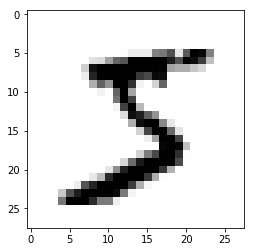

In [11]:
plt.imshow(images_X[0].reshape(28, 28), cmap=plt.cm.gray_r)

images_y[0]

In [12]:
# scale images_X to be beteen 0 and 1
images_X = images_X / 255.

In [14]:
# make pixels binary (either white or black)
images_X = (images_X > 0.5).astype(float)
np.min(images_X), np.max(images_X)

(0.0, 1.0)

5.0

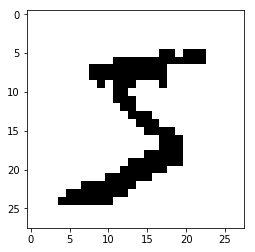

In [15]:
# 二值化后，图像的模糊消失了
plt.imshow(images_X[0].reshape(28, 28), cmap=plt.cm.gray_r)

images_y[0]

In [21]:
# 使用 RBM 提取特征，并使用 LR 进行预测
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

rbm = BernoulliRBM(random_state=0)
lr = LogisticRegression()

params = {'clf__C': [1e-1, 1e0, 1e1],
         'rbm__n_components': [100, 200]}

# 创建 Pipline
pipeline = Pipeline([('rbm', rbm), ('clf', lr)])

# 实例化网格化搜索
grid = GridSearchCV(pipeline, param_grid=params)
grid.fit(images_X, images_y)

grid.best_params_, grid.best_score_

({'clf__C': 1.0, 'rbm__n_components': 200}, 0.9138333333333334)

## 词嵌入(embedding) Word2vec

词嵌入将词转换为向量，可以应用于词相似计算，信息检索，特征表示等。


In [31]:
# 设置日志，方便查看训练过程
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

import gensim

In [26]:
from gensim.models import word2vec, Word2Vec

sentences = word2vec.Text8Corpus('../data/feature_engineering/text8')

2019-12-08 15:21:02,212 'pattern' package not found; tag filters are not available for English


In [27]:
# instantiate a gensim module on the sentences from above
# min_count allows us to ignore words that occur strictly less than this value
# size is the dimension of words we wish to learn
model = Word2Vec(sentences, min_count=1, size=20)

2019-12-08 15:21:51,677 collecting all words and their counts
2019-12-08 15:21:51,687 PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-08 15:21:55,607 collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
2019-12-08 15:21:55,607 Loading a fresh vocabulary
2019-12-08 15:21:56,110 min_count=1 retains 253854 unique words (100% of original 253854, drops 0)
2019-12-08 15:21:56,111 min_count=1 leaves 17005207 word corpus (100% of original 17005207, drops 0)
2019-12-08 15:21:56,732 deleting the raw counts dictionary of 253854 items
2019-12-08 15:21:56,736 sample=0.001 downsamples 36 most-common words
2019-12-08 15:21:56,736 downsampling leaves estimated 12819131 word corpus (75.4% of prior 17005207)
2019-12-08 15:21:57,262 estimated required memory for 253854 words and 20 dimensions: 167543640 bytes
2019-12-08 15:21:57,262 resetting layer weights
2019-12-08 15:21:59,279 training model with 3 workers on 253854 vocabulary and 20 features, us

In [29]:
# 查看单词的 embedding
model.wv['king']

array([-2.0125573 ,  0.2544487 ,  5.076512  ,  2.641983  , -1.4323539 ,
       -3.1821811 , -2.5331855 , -3.0314212 ,  1.0664788 , -2.329465  ,
        3.3908658 , -3.341876  ,  4.5301423 , -0.52069855,  0.48848453,
       -1.2554439 ,  7.6860123 , -5.3749785 , -2.8794553 , -0.398532  ],
      dtype=float32)

In [34]:
# 导入预训练词库
# 此数据下载地址： https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
model = gensim.models.KeyedVectors.load_word2vec_format('../data/feature_engineering/GoogleNews-vectors-negative300.bin', binary=True)

2019-12-08 15:43:05,001 loading projection weights from ../data/feature_engineering/GoogleNews-vectors-negative300.bin
2019-12-08 15:43:41,836 loaded (3000000, 300) matrix from ../data/feature_engineering/GoogleNews-vectors-negative300.bin


In [36]:
# 女 + 国王 - 男 = 女王
model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

2019-12-08 15:44:30,173 precomputing L2-norms of word weight vectors


[('queen', 0.7118192911148071)]

In [38]:
# London is to England as Paris is to ____
model.wv.most_similar(positive=['Paris', 'England'], negative=['London'], topn=1)

[('France', 0.667637825012207)]

信息检索应用

In [39]:
# helper function to try to grab embeddings for a word and returns None if that word is not found
def get_embedding(string):
    try:
        return model.wv[string]
    except:
        return None

In [40]:
sentences = [
    "this is about a dog",
    "this is about a cat",
    "this is about nothing"
]

In [47]:
from functools import reduce
# Zero matrix of shape (3,300)
vectorized_sentences = np.zeros((len(sentences),300))
# for every sentence
for i, sentence in enumerate(sentences):
    # tokenize sentence into words
    words = sentence.split(' ')
    # embed whichever words that we can
    embedded_words = [get_embedding(w) for w in words]
    embedded_words = list(filter(lambda x:x is not None, embedded_words))
    # Take a mean of the vectors, to get an estimate vectorization of the entire title
    vectorized_sentence = reduce(lambda x,y:x+y, embedded_words)/ len(embedded_words)
    # change the ith row (in place) to be the ith vectorization
    vectorized_sentences[i:] = vectorized_sentence

In [48]:
vectorized_sentences.shape

(3, 300)

In [49]:
# we want articles most similar to the reference word "dog"
reference_word = 'dog'

# take a dot product between the embedding of dof and our vectorized matrix
best_sentence_idx = np.dot(vectorized_sentences, get_embedding(reference_word)).argsort()[-1]

# output the most relevant sentence
sentences[best_sentence_idx]

'this is about a dog'